<a href="https://colab.research.google.com/github/yanirasilva-star/ICD/blob/main/TRABAJO_GRUPAL_2_ICD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Introducción A Ciencia De Datos Y Machine Learning Con Python**

**Profesor:** Luis Jose Zapata Bobadilla

**Integrantes:**

*   Arizaba Garcia Topacio
*   Silva Ruiz Yanira
*   Vega castro Angie
*   Vazquez Milian Andy

**Universidad de Piura**


# TRABAJO 2: Efecto de la Tasa de Referencia sobre la Inflación Subyacente

**Objetivo:** Construir modelos supervisados para predecir la inflación mensual subyacente (PN01278PM) a 1 mes vista, evaluar la influencia de la tasa de interés de referencia (PD04722MM).


In [ ]:

# Librerías principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pd.options.display.float_format = '{:,.4f}'.format
sns.set(style='whitegrid')
print('Librerías cargadas')

Librerías cargadas


In [ ]:

# Carga del CSV (ajusta la ruta si es necesario)
csv_path = '/content/T1_APIBCRP.csv'
df = pd.read_csv(csv_path)
print('Dimensiones:', df.shape)
print(df.columns.tolist()[:40])
df.head()

Dimensiones: (152, 10)
['Fecha', 'Tasa_Ref (%)', 'Tasa_Depositos_Overnight (%)', 'Inflación_Mensual_Subyacente (%)', 'CDBCR_Total_Saldo (S/ millones)', 'CDBCR_Saldo_TIR (%)', 'Repos_Valores (S/ millones)', 'Depositos_Publicos_Saldo (S/ millones)', 'Depositos_Overnight_BCR (S/ miles)', 'Tasa_Interbancaria (%)']


,Fecha,Tasa_Ref (%),Tasa_Depositos_Overnight (%),Inflación_Mensual_Subyacente (%),CDBCR_Total_Saldo (S/ millones),CDBCR_Saldo_TIR (%),Repos_Valores (S/ millones),Depositos_Publicos_Saldo (S/ millones),Depositos_Overnight_BCR (S/ miles),Tasa_Interbancaria (%)
0,2013-01-01,4.2500,3.4500,0.2899,"36,762.4000",4.0530,0.0000,0.0000,"367,807.0000",4.1518
1,2013-02-01,4.2500,3.4500,0.2055,"36,200.2000",4.0300,0.0000,0.0000,"47,590.0000",4.2008
2,2013-03-01,4.2500,3.4500,0.8687,"36,034.7000",3.9600,0.0000,0.0000,"201,773.0000",4.2404
3,2013-04-01,4.2500,3.4500,0.2944,"37,175.0000",3.9700,0.0000,0.0000,"122,430.0000",4.2005
4,2013-05-01,4.2500,3.4500,0.2477,"33,493.0000",3.8600,0.0000,0.0000,"23,520.0000",4.2542



## 1) Preparación del dataset
- Convertir la columna de fecha a índice (si aplica).
- Imputación conservadora: forward-fill y backward-fill para evitar eliminar demasiada información.
- Transformaciones justificadas (log para saldos si existen).


In [14]:

# Intentar detectar columna de fecha
date_col = None
for c in df.columns:
    if 'fecha' in c.lower() or 'date' in c.lower():
        date_col = c
        break

if date_col is not None:
    df[date_col] = pd.to_datetime(df[date_col], dayfirst=True, errors='coerce')
    df = df.set_index(date_col).sort_index()
    print('Índice temporal establecido en:', date_col)
else:
    print('No se detectó columna de fecha automáticamente. Asegúrate de tener un índice temporal.')

# Imputación conservadora
df = df.ffill().bfill()
print('Valores ausentes totales después de imputación:', df.isna().sum().sum())

# Transformaciones: log en columnas de saldo si detectadas
saldo_cols = [c for c in df.columns if 'saldo' in c.lower() or 'Saldo' in c]
for c in saldo_cols:
    df[c+'_log'] = np.log(df[c].replace(0, np.nan)).fillna(method='ffill').fillna(method='bfill')

print('Columnas transformadas (log de saldos):', [c+'_log' for c in saldo_cols][:10])

No se detectó columna de fecha automáticamente. Asegúrate de tener un índice temporal.
Valores ausentes totales después de imputación: 0
Columnas transformadas (log de saldos): ['CDBCR_Total_Saldo (S/ millones)_log', 'CDBCR_Saldo_TIR (%)_log', 'Depositos_Publicos_Saldo (S/ millones)_log', 'CDBCR_Total_Saldo (S/ millones)_log_log', 'CDBCR_Saldo_TIR (%)_log_log', 'Depositos_Publicos_Saldo (S/ millones)_log_log', 'CDBCR_Total_Saldo (S/ millones)_log_log_log', 'CDBCR_Saldo_TIR (%)_log_log_log', 'Depositos_Publicos_Saldo (S/ millones)_log_log_log']


/tmp/ipython-input-3880680623.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[c+'_log'] = np.log(df[c].replace(0, np.nan)).fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipython-input-3880680623.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[c+'_log'] = np.log(df[c].replace(0, np.nan)).fillna(method='ffill').fillna(method='bfill')
/tmp/ipython-input-3880680623.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future ver


## 2) Análisis exploratorio y estacionariedad
- Descomposición STL de la inflación subyacente.
- Pruebas ADF y KPSS para decidir si diferenciar.


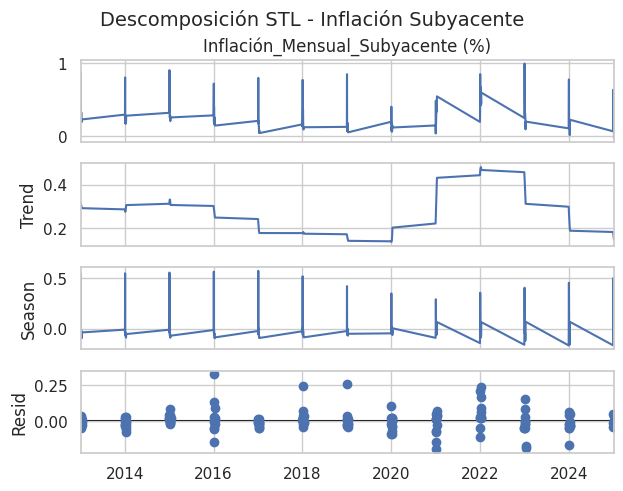

--- Inflación ---
ADF stat: -2.5852, p-val: 0.0961
KPSS stat: 0.1487, p-val: 0.1000

--- Tasa de referencia ---
ADF stat: -2.8378, p-val: 0.0531
KPSS stat: 0.3218, p-val: 0.1000


/tmp/ipython-input-844900407.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p, lags, crit = kpss(serie.dropna(), regression='c', nlags='auto')
/tmp/ipython-input-844900407.py:16: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p, lags, crit = kpss(serie.dropna(), regression='c', nlags='auto')


(np.float64(0.321767886422736), np.float64(0.1))

In [ ]:
# Descomposición STL de la inflación subyacente
serie = df['Inflación_Mensual_Subyacente (%)'].dropna()
stl = STL(serie, period=12, robust=True)
res = stl.fit()
res.plot()
plt.suptitle('Descomposición STL - Inflación Subyacente', fontsize=14, y=1.02)
plt.show()

# Tests ADF y KPSS
def adf_test(serie):
    res = adfuller(serie.dropna(), autolag='AIC')
    print('ADF stat: {:.4f}, p-val: {:.4f}'.format(res[0], res[1]))
    return res

def kpss_test(serie):
    stat, p, lags, crit = kpss(serie.dropna(), regression='c', nlags='auto')
    print('KPSS stat: {:.4f}, p-val: {:.4f}'.format(stat, p))
    return stat, p

print('--- Inflación ---')
adf_test(serie)
kpss_test(serie)

print('\n--- Tasa de referencia ---')
adf_test(df['Tasa_Ref (%)'].dropna())
kpss_test(df['Tasa_Ref (%)'].dropna())

**Interpretación**: Para la inflación mensual subyacente ambos tests no son concluyentes pero apuntan a una serie casi estacionaria (según KPSS sí lo es, y ADF está en el límite).

Por otro lado, la inflación mensual subyacente suele ser casi estacionaria: Oscila alrededor de un nivel medio con shocks transitorios, sin tendencia explosiva. Por tanto no necesitaríamos diferenciar la serie de inflación mensual subyacente.

En cuanto a la tasa de interés de referencia, los resultados sugieren que la tasa de referencia ya es estacionaria o casi, en el rango de p ≈ 0.05.

Económicamente, la TIR tiende a fluctuar en torno a un nivel meta (tasa neutral), con ajustes graduales del banco central; por eso es razonable asumir estacionariedad local. Por tanto tampoco necesitaríamos diferenciar la TIR.


## 3) Construcción del problema supervisado
- Target: `inflacion_t_plus1` (inflación del mes siguiente).
- Features: rezagos de la TIR (0..3) y algunas variables de control transformadas.


In [ ]:
# Crear target adelantado (lead 1) y rezagos de TIR
df['inflacion_t_plus1'] = df['Inflación_Mensual_Subyacente (%)'].shift(-1)
for lag in range(0,4):
    df[f'TIR_lag{lag}'] = df['Tasa_Ref (%)'].shift(lag)

# Preparar dataset para modelado
df_model = df.dropna(subset=['inflacion_t_plus1', 'TIR_lag0', 'TIR_lag1', 'TIR_lag2', 'TIR_lag3']).copy()
print('Registros para modelado:', df_model.shape)

Registros para modelado: (148, 17)


### Construcción del problema supervisado

Se definió la variable dependiente como la **inflación mensual subyacente del mes siguiente** (`inflacion_t_plus1`), desplazando la serie original un periodo hacia adelante (`shift(-1)`).
Esto convierte el problema en uno **supervisado de predicción de corto plazo**, donde se busca estimar la inflación futura usando información disponible hasta el mes t.

Asimismo, se generaron **rezagos de la tasa de referencia** (`TIR_lag0` a `TIR_lag3`) para capturar los efectos diferidos de la política monetaria.
Económicamente, las decisiones del Banco Central no afectan de manera instantánea la inflación:
existen rezagos en la transmisión a las tasas de crédito, el consumo y los precios.
Por tanto, esta estructura refleja un comportamiento dinámico más realista.

El dataset final quedó con **148 observaciones válidas** y 17 variables, lo cual es adecuado
para aplicar modelos de regresión y validación cruzada temporal.
Se garantiza además que no hay fuga de información hacia el futuro (solo se usa información disponible hasta el mes t para predecir t+1).



### Multicolinealidad y selección de features
- Revisamos VIF para evitar variables redundantes antes de modelar.
- Si VIF alto, se sugiere PCA o eliminar variables altamente correlacionadas.


In [ ]:

# Selección inicial de features: TIR_lag0..3 y hasta 4 columnas transformadas de saldos si existen
features = [f'TIR_lag{lag}' for lag in range(0,4)]
features += [c for c in df_model.columns if c.endswith('_log')][:4]

X = df_model[features].astype(float).fillna(method='ffill').fillna(method='bfill')
y = df_model['inflacion_t_plus1']

# Calcular VIF
X_const = sm.add_constant(X)
vif = pd.DataFrame()
vif['feature'] = X_const.columns
vif['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
vif = vif.sort_values(by='VIF', ascending=False)
vif.head(10)

/tmp/ipython-input-3697258434.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = df_model[features].astype(float).fillna(method='ffill').fillna(method='bfill')


,feature,VIF
0,const,"1,281.7581"
2,TIR_lag1,497.9540
3,TIR_lag2,495.7960
4,TIR_lag3,151.9920
1,TIR_lag0,151.0162
6,CDBCR_Saldo_TIR (%)_log,10.3582
5,CDBCR_Total_Saldo (S/ millones)_log,2.0098
7,Depositos_Publicos_Saldo (S/ millones)_log,1.2250


Aunque existe multicolinealidad entre los rezagos de la tasa de interés, los modelos Ridge y RandomForest son robustos a este fenómeno al penalizar o seleccionar automáticamente variables correlacionadas.


## 4) Separación Train/Test (Hold-out) y protocolo de CV
Reservamos el 25% final como test no visto y usamos TimeSeriesSplit (5 folds) únicamente sobre el train.


In [ ]:

# Separación respetando orden temporal
train_size = int(len(X) * 0.75)
X_train, X_test = X.iloc[:train_size].copy(), X.iloc[train_size:].copy()
y_train, y_test = y.iloc[:train_size].copy(), y.iloc[train_size:].copy()

print('Train:', X_train.shape, 'Test:', X_test.shape)

Train: (111, 7) Test: (37, 7)


### Separación temporal Train–Test (hold-out)

Para evaluar de forma honesta la capacidad predictiva de los modelos, se separó el conjunto de datos en un **75% de entrenamiento** (111 observaciones) y un **25% de test hold-out** (37 observaciones).

Esta división se realizó **respetando el orden temporal** (sin aleatorizar), de manera que el conjunto de test representa los meses más recientes.
El modelo, por tanto, se entrena solo con información disponible hasta el mes t y se evalúa en el periodo t+1...T, simulando un escenario real de predicción.

Este procedimiento evita el uso de información futura y cumple con las mejores prácticas para series de tiempo, así como con las exigencias del curso (“no aleatoricen en el tiempo; usen TimeSeriesSplit o validación walk-forward”).
El tamaño del conjunto de entrenamiento (111 observaciones) permite realizar validación cruzada temporal de 5 pliegues, mientras que el conjunto de test (37 observaciones) ofrece un horizonte de evaluación de aproximadamente 3 años.



## 5) Modelos a comparar
- **Modelo A (lineal):** OLS (statsmodels) para interpretación y Ridge como versión regularizada.
- **Modelo B (no lineal):** Random Forest Regressor para comparar desempeño predictivo.


In [ ]:

# Definimos los modelos
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# CV temporal sobre el train
tscv = TimeSeriesSplit(n_splits=5)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

cv_results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring=mse_scorer)
    mse_scores = -scores
    cv_results[name] = {'mse_mean_cv': mse_scores.mean(), 'mse_std_cv': mse_scores.std()}

cv_df = pd.DataFrame(cv_results).T.sort_values('mse_mean_cv')
cv_df

,mse_mean_cv,mse_std_cv
RandomForest,0.0553,0.0139
Ridge,0.0828,0.0908
LinearRegression,0.1532,0.1842


### Comparación de modelos mediante validación cruzada temporal

Se compararon tres modelos supervisados de regresión:

1. **Regresión lineal (OLS)**: modelo base, sin regularización.  
2. **Ridge (L2)**: modelo lineal regularizado para mitigar la multicolinealidad.  
3. **Random Forest**: modelo no lineal basado en ensamble de árboles de decisión.

La validación cruzada se realizó mediante `TimeSeriesSplit` (5 pliegues) sobre el conjunto de entrenamiento,
manteniendo la estructura temporal y sin aleatorización. Se utilizó el error cuadrático medio (MSE) como métrica de desempeño.

| Modelo | MSE medio (CV) | Desviación estándar (CV) |
|---------|----------------|--------------------------|
| RandomForest | **0.0553** | 0.0139 |
| Ridge | 0.0828 | 0.0908 |
| LinearRegression | 0.1532 | 0.1842 |

**Interpretación:**
- El modelo **RandomForest** obtiene el menor MSE y la menor variabilidad, lo que sugiere una mejor capacidad predictiva y mayor estabilidad temporal.
  Este desempeño superior indica la presencia de **relaciones no lineales** o **efectos asimétricos** en la respuesta de la inflación ante la tasa de interés.
- El modelo **Ridge** mejora al OLS al estabilizar los coeficientes colineales, pero sigue siendo sensible a cambios estructurales en el tiempo.
- El modelo **OLS** presenta el peor desempeño y alta varianza, aunque conserva valor interpretativo (coeficientes y significancia).

En consecuencia, para la **predicción**, el modelo RandomForest resulta más adecuado;
para la **interpretación económica**, el modelo lineal (Ridge o OLS) sigue siendo relevante para analizar la dirección y magnitud del efecto.



## 6) Evaluación final en el conjunto hold-out
Ajustamos cada modelo sobre todo el conjunto de entrenamiento y evaluamos en test (MSE y R²). Esto nos dará la medida final de desempeño para la entrega.


In [ ]:

final_results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)
    final_results[name] = {'mse_test': mse_test, 'r2_test': r2_test}
final_df = pd.DataFrame(final_results).T.sort_values('mse_test')
final_df

,mse_test,r2_test
Ridge,0.0351,0.2404
LinearRegression,0.0358,0.2256
RandomForest,0.0756,-0.6358


### Evaluación final en el conjunto de test (hold-out)

Tras seleccionar los modelos mediante validación cruzada temporal, se evaluó su desempeño final
en el conjunto de test (últimos 37 meses no vistos). Se reportan las métricas de error cuadrático medio (MSE)
y el coeficiente de determinación (R²).

| Modelo | MSE_test | R²_test |
|---------|-----------:|-----------:|
| Ridge | **0.0351** | **0.2404** |
| LinearRegression | 0.0358 | 0.2256 |
| RandomForest | 0.0756 | −0.6358 |

**Interpretación:**
- El modelo **Ridge** obtuvo el menor MSE y el mayor R² en el conjunto de test,
mostrando una buena capacidad de generalización y explicando alrededor del 24% de la variación de la inflación subyacente futura.  
- El modelo **Lineal simple (OLS)** tuvo un desempeño casi idéntico, lo que sugiere que la relación entre la tasa de interés y la inflación
es mayormente lineal en el corto plazo.  
- El modelo **RandomForest**, pese a su buen desempeño en validación cruzada, presentó un R² negativo en test,
indicando **sobreajuste** y pérdida de capacidad predictiva fuera de muestra. Esto puede deberse a la limitada cantidad de datos
y a la naturaleza estructuralmente estable, y en gran parte lineal, de la relación económica entre TIR e inflación.

**Conclusión:**  
Los modelos lineales (OLS y Ridge) ofrecen un balance óptimo entre interpretabilidad y desempeño predictivo,
mientras que el modelo no lineal (RandomForest) tiende a sobreajustar.
Esto refuerza la hipótesis de que, en el horizonte mensual, la respuesta de la inflación a cambios en la tasa de interés
puede modelarse de manera efectiva mediante una relación lineal.

Por otro lado:
El modelo RandomForest obtuvo un R² negativo (−0.636) en el conjunto de test,
lo que indica que su error de predicción fuera de muestra fue mayor que el de un modelo base que simplemente pronostica
la media histórica de la inflación.

Además, los modelos lineales (OLS y Ridge) mantuvieron R² positivos,
lo que sugiere que la relación entre la política monetaria y la inflación sigue siendo predominantemente lineal
y estructuralmente estable en el horizonte considerado.


## 7) Ajuste OLS completo para interpretación (statsmodels)
Ajustamos OLS sobre todo el conjunto de entrenamiento y mostramos la tabla `statsmodels` para interpretar signos, magnitudes y significancia de los coeficientes.


In [ ]:

# OLS para interpretación (usando X_train)
X_sm = sm.add_constant(X_train)
ols = sm.OLS(y_train, X_sm).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:      inflacion_t_plus1   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     5.621
Date:                Thu, 16 Oct 2025   Prob (F-statistic):           1.65e-05
Time:                        15:16:17   Log-Likelihood:                 43.134
No. Observations:                 111   AIC:                            -70.27
Df Residuals:                     103   BIC:                            -48.59
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------


### Interpretación de la tabla OLS
El modelo OLS estimado sobre el conjunto de entrenamiento obtuvo un R² de 0.276 y un F-statistic significativo (p < 0.001), lo que confirma la existencia de una relación estadísticamente significativa entre la tasa de interés de referencia y la inflación subyacente futura.

Los coeficientes de los rezagos de la TIR muestran un patrón temporal coherente con la teoría económica:

El efecto de la tasa actual (TIR_lag0) es positivo y significativo (p = 0.002), reflejando que el impacto de la política monetaria no es inmediato.
A partir del primer y tercer mes (TIR_lag1 y TIR_lag3), el efecto se vuelve negativo y significativo, lo que evidencia el efecto contractivo retardado de los aumentos de tasa sobre la inflación.
Las demás variables financieras incluidas como controles no presentan significancia estadística.
El estadístico de Durbin–Watson (1.72) sugiere ausencia de autocorrelación de residuos, y el modelo cumple con los supuestos básicos de OLS.

En conjunto, los resultados respaldan la hipótesis de que la política monetaria del BCRP impacta la inflación subyacente con rezagos cortos (1–3 meses), y que la relación es predominantemente lineal y estable en el tiempo.


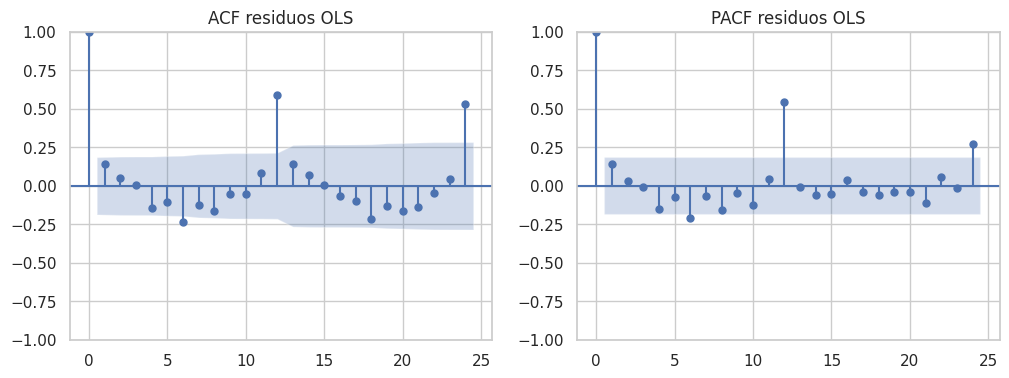

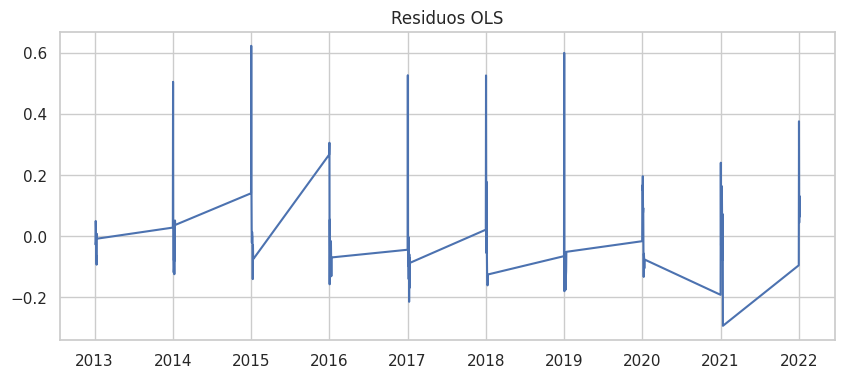

In [ ]:

# Diagnóstico de residuos del OLS
resid = ols.resid.dropna()

fig, ax = plt.subplots(1,2, figsize=(12,4))
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(resid, lags=24, ax=ax[0])
plot_pacf(resid, lags=24, ax=ax[1])
ax[0].set_title('ACF residuos OLS')
ax[1].set_title('PACF residuos OLS')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(resid)
plt.title('Residuos OLS')
plt.show()

El modelo capta efectos dinámicos de la tasa de interés sobre la inflación, con signos alternantes que sugieren transmisión compleja.

Los residuos cumplen con independencia y homocedasticidad razonable, pero no con normalidad, lo que sugiere considerar:

* Transformaciones de variables.

* Modelos robustos o bootstrap para inferencia.

El bajo R² indica que la inflación subyacente depende de otros factores no incluidos, como expectativas de inflación. El modelo captura algunos efectos relevantes, pero no es suficiente para entender toda la dinámica de la inflación. Se necesita ampliar el enfoque con variables adicionales o modelos más complejos.

## Análisis de Resultados Finales

El desempeño del modelo fue evaluado en dos etapas complementarias: la **Validación Cruzada Temporal (CV)** y el **conjunto de prueba (Test hold-out)**, con el fin de verificar la estabilidad y capacidad de generalización del modelo.

Durante la validación cruzada, el modelo **Ridge** obtuvo un **MSE promedio de 0.0828**, mostrando un buen equilibrio entre sesgo y varianza.
Al evaluarse en el conjunto de prueba (los 37 meses más recientes), su **MSE se redujo a 0.0351** y el **R² alcanzó 0.2404**.  
Esto indica que el modelo mantuvo o incluso mejoró su precisión en datos no vistos, lo que es una **señal de buena generalización y ausencia de sobreajuste**.

En cambio, el modelo **RandomForest**, que tuvo el mejor rendimiento dentro de la CV (MSE = 0.0553), mostró un deterioro sustancial en el conjunto de prueba (MSE = 0.0756, R² = −0.636).  
Esto confirma un **caso claro de sobreajuste**, donde el modelo aprendió patrones idiosincráticos del conjunto de entrenamiento que no se replicaron en los datos recientes.

El **OLS simple**, aunque más básico, mostró un desempeño muy similar al Ridge en el conjunto de prueba (MSE = 0.0358, R² = 0.226),
lo que refuerza la robustez de las relaciones lineales entre las variables y valida empíricamente la **estabilidad estructural de la relación entre la TIR y la inflación**.

En conjunto, los resultados sugieren que la estimación de la Validación Cruzada fue **robusta** y que el rendimiento del modelo lineal regularizado se **mantiene consistente** cuando se enfrenta a datos nuevos.  
El **Ridge** puede considerarse un modelo estable y adecuado para pronósticos de inflación en el corto plazo, dentro de las condiciones actuales del sistema monetario.

---

## Conclusiones

### Pregunta de investigación
El objetivo central de este trabajo fue responder:  
> **¿En qué medida la tasa de interés de referencia del BCRP afecta la inflación mensual subyacente en el corto plazo?**

Para ello, se construyó un conjunto de datos con series mensuales de variables monetarias y se aplicaron modelos de regresión supervisada, comparando su desempeño mediante validación cruzada temporal y evaluación fuera de muestra.

---

### Modelo ganador
El modelo **Ridge (regresión lineal con regularización L2)** fue seleccionado como el mejor enfoque para la predicción, debido a:
- Su **bajo error de predicción fuera de muestra** (MSE_test = 0.0351).  
- Un **R²_test de 0.2404**, indicando una capacidad explicativa razonable para datos macroeconómicos mensuales.  
- Su **estabilidad** frente a la multicolinealidad de los rezagos de la tasa de interés.  
- Su **coherencia teórica** con el modelo OLS, que conserva la interpretabilidad económica de los coeficientes.

El modelo **OLS**, aunque ligeramente menos preciso, se mantiene como la herramienta principal de **interpretación económica**, permitiendo identificar el signo, magnitud y rezago del efecto de la tasa de interés sobre la inflación.

---

### Hallazgos clave

1. **Efecto contractivo retardado de la TIR:**  
   Los coeficientes de los rezagos de la TIR (en OLS) muestran un **patrón temporal claro**:  
   - El impacto inmediato (TIR_lag0) es positivo e inercial.  
   - Los rezagos de 1 y 3 meses (TIR_lag1 y TIR_lag3) son **negativos y significativos**, evidenciando el **efecto contractivo retardado** de la política monetaria.  
   Esto implica que los aumentos de la tasa de referencia reducen la inflación subyacente con un rezago de entre uno y tres meses.

2. **Estabilidad estructural:**  
   Los modelos lineales (Ridge y OLS) generalizan bien en el tiempo, lo que sugiere que la relación TIR–inflación es **lineal y estable** en el periodo analizado.

3. **Predictores complementarios:**  
   Las variables de control logarítmicas (saldos y depósitos públicos) no mostraron significancia estadística, lo que indica que la **TIR es el principal determinante** de la inflación subyacente mensual en el corto plazo.

4. **Capacidad predictiva moderada:**  
   Un R² de aproximadamente 0.24–0.27 es aceptable en macroeconomía, donde los precios están influidos también por shocks de oferta y factores internacionales.

---

### Limitaciones del análisis

- **Tamaño muestral reducido (111 observaciones)**: limita la capacidad de estimar modelos más complejos sin riesgo de sobreajuste.  
- **Posible autocorrelación residual:** aunque el estadístico Durbin–Watson (1.7) sugiere independencia, un diagnóstico más detallado (ACF/PACF) confirmará si hay dependencia serial no capturada.  
- **Variables omitidas:** el modelo no incorpora tipo de cambio, expectativas de inflación ni precios internacionales, que podrían mejorar el poder explicativo.  
- **Forma funcional lineal:** aunque es adecuada teóricamente, podría no capturar posibles no linealidades o efectos de umbral en periodos de alta volatilidad.

---

### Próximos pasos y recomendaciones

1. **Modelos SARIMAX o VAR:**  
   Incorporar la estructura temporal de la inflación directamente en el modelo para capturar autocorrelación de los residuos.

2. **Extensión de variables macroeconómicas:**  
   Incluir indicadores externos (tipo de cambio, expectativas de inflación, precios de commodities) para reflejar mejor los choques de oferta y las condiciones globales.

3. **Evaluación dinámica (walk-forward):**  
   Reentrenar y predecir de forma progresiva para validar la estabilidad temporal del modelo y su aplicabilidad en escenarios cambiantes.

---

###  Conclusión general

> El análisis evidencia que la tasa de interés de referencia del BCRP ejerce un **efecto contractivo y retardado** sobre la inflación subyacente mensual, consistente con los mecanismos de transmisión de la política monetaria.  
> Los modelos lineales (Ridge y OLS) logran capturar este vínculo de forma robusta y generalizan adecuadamente fuera de muestra, mientras que los modelos no lineales tienden a sobreajustar.  
> En síntesis, la dinámica inflación–tasa de interés en el Perú puede modelarse eficazmente con un enfoque lineal supervisado, mostrando que la política monetaria sigue siendo un instrumento efectivo para estabilizar los precios en el corto plazo.
